In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from wordcloud import WordCloud
from textwrap import wrap
import unicodedata
from textblob import TextBlob

# Ruta de los datos
# "..\Data\Banco-Preguntas-Icfes.txt"

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
file_path = "../Data/Banco-Preguntas-Icfes.txt"

# Read the file line by line
with open(file_path, "r", encoding="utf-8") as file:
    lines = file.readlines()

# Display the first 10 lines to check the format
print("File content (first 10 lines):\n")
for i, line in enumerate(lines[:10]):
    print(f"Line {i+1}: {line.strip()}")



File content (first 10 lines):

Line 1: Pregunta: ¿En qué fechas se dará inicio al proceso de registro e inscripción a los exámenes?
Line 2: Respuesta: Validar en la página www.icfes.gov.co / Evaluaciones y Elija el examen de su interés.
Line 3: 
Line 4: Pregunta:¿Cómo puedo cambiar el correo de notificaciones asociado al usuario PRISMA de mi sede jornada?
Line 5: Respuesta:A través del Chat, ingresando a la  página www.icfes.gov.co / Atención y servicios a la ciudadanía / canales de atención / Chat.(Link:https://www.icfes.gov.co/atencion-y-servicios-a-la-ciudadania/canales-de-atencion/)
Line 6: 
Line 7: Pregunta:¿qué debo hacer para presentar las pruebas icfes por segunda vez?
Line 8: Respuesta:Se puede registrar las veces que desee, después de la quinta inscripción la tarifa aumenta, validar en  la página www.icfes.gov.co / Evaluaciones y Elija el examen de su interés.
Line 9: 
Line 10: Pregunta:¿El examen saber 11°, entrega certificado o constancia de asistencia?


In [3]:
# Leer el archivo y contar palabras
with open(file_path, "r", encoding="utf-8") as file:
    contenido = file.read()

# Contar el total de palabras
total_palabras = len(contenido.split())

# Mostrar el resultado
print(f"📊 Total de palabras en el archivo: {total_palabras}")

📊 Total de palabras en el archivo: 1230


In [34]:
# Initialize lists to store questions and answers
preguntas = []
respuestas = []
pregunta_actual = ""
respuesta_actual = ""
leyendo_respuesta = False

# Read the file line by line and separate questions and answers
with open(file_path, "r", encoding="utf-8") as file:
    for line in file:
        line = line.strip()

        # Detect questions
        if line.startswith("Pregunta:"):
            if pregunta_actual:
                preguntas.append(pregunta_actual.strip())
                respuestas.append(respuesta_actual.strip())
            pregunta_actual = line.replace("Pregunta:", "").strip()
            respuesta_actual = ""
            leyendo_respuesta = False

        # Detect answers
        elif line.startswith("Respuesta:"):
            leyendo_respuesta = True
            respuesta_actual = line.replace("Respuesta:", "").strip()

        # Add content to the question or answer
        else:
            if leyendo_respuesta:
                respuesta_actual += " " + line.strip()
            else:
                pregunta_actual += " " + line.strip()

# Add the last question and answer
if pregunta_actual:
    preguntas.append(pregunta_actual.strip())
    respuestas.append(respuesta_actual.strip())

# Create separate DataFrames for questions and answers
df_preguntas = pd.DataFrame({"Pregunta": preguntas})
df_respuestas = pd.DataFrame({"Respuesta": respuestas})

# Display the first rows of each DataFrame
print("\n📊 First extracted questions:")
print(df_preguntas.head())

print("\n📊 First extracted answers:")
print(df_respuestas.head())

# Show the total number of extracted questions and answers
print(f"\nTotal extracted questions: {len(df_preguntas)}")
print(f"Total extracted answers: {len(df_respuestas)}")



📊 First extracted questions:
                                            Pregunta
0  ¿En qué fechas se dará inicio al proceso de re...
1  ¿Cómo puedo cambiar el correo de notificacione...
2  ¿qué debo hacer para presentar las pruebas icf...
3  ¿El examen saber 11°, entrega certificado o co...
4                       ¿Debo pagar las pruebas TyT?

📊 First extracted answers:
                                           Respuesta
0  Validar en la página www.icfes.gov.co / Evalua...
1  A través del Chat, ingresando a la  página www...
2  Se puede registrar las veces que desee, despué...
3  No, únicamente se genera certificado de asiste...
4  Valida las tarifas en la página www.icfes.gov....

Total extracted questions: 26
Total extracted answers: 26


# Punto critico de limpieza, se borra los caracteres especiales, tildes, numeros y se pasa todo a minusculas
Nota: para entregar los datos al RAG se puesden guardar un mapeo de los datos originales y el modelo trabaje con los datos limpios, y antes de entregar la respuesta al usuario busque en el mapeo el dato original y lo devuelva al usuario

```python

In [35]:
# Function to clean the text
def limpiar_texto(texto):
    if pd.isna(texto):  # Check if the text is NaN or None
        return ""
    
    texto = str(texto).lower()  # Convert to lowercase
    texto = unicodedata.normalize('NFKD', texto).encode('ASCII', 'ignore').decode('utf-8')  # Remove accents
    texto = re.sub(r'\d+', '', texto)  # Remove numbers
    texto = re.sub(r'[^\w\s]', '', texto)  # Remove special characters
    texto = re.sub(r'\b[a-zA-Z]\b', '', texto)  # Remove single-character words
    texto = re.sub(r'\s+', ' ', texto).strip()  # Remove extra spaces
    
    return texto

# Apply the cleaning function to the DataFrames
df_preguntas["Pregunta"] = df_preguntas["Pregunta"].apply(limpiar_texto)
df_respuestas["Respuesta"] = df_respuestas["Respuesta"].apply(limpiar_texto)

# Display the first rows of the cleaned DataFrames
print("\nFirst cleaned questions:")
print(df_preguntas.head())

print("\nFirst cleaned answers:")
print(df_respuestas.head())




First cleaned questions:
                                            Pregunta
0  en que fechas se dara inicio al proceso de reg...
1  como puedo cambiar el correo de notificaciones...
2  que debo hacer para presentar las pruebas icfe...
3  el examen saber entrega certificado constancia...
4                         debo pagar las pruebas tyt

First cleaned answers:
                                           Respuesta
0  validar en la pagina wwwicfesgovco evaluacione...
1  traves del chat ingresando la pagina wwwicfesg...
2  se puede registrar las veces que desee despues...
3  no unicamente se genera certificado de asisten...
4  valida las tarifas en la pagina wwwicfesgovco ...


Nube de palabras - Preguntas


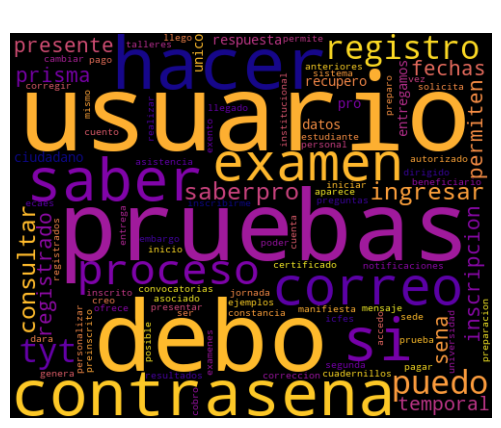

Nube de palabras - Respuestas


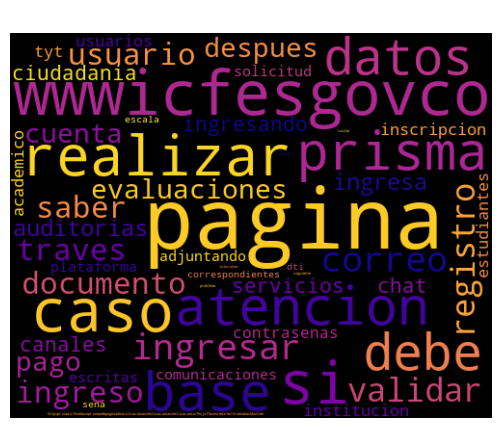

In [6]:
stop_words = set(stopwords.words("spanish"))

# Función para limpiar y tokenizar sin `word_tokenize()`
def tokenizar_y_filtrar(texto):
    tokens = re.findall(r'\b\w+\b', texto.lower())  # Extraer solo palabras
    tokens = [word for word in tokens if word not in stop_words]  # Filtrar stopwords
    return tokens

#  Tokenizar preguntas y respuestas
tokens_preguntas = [token for pregunta in df_preguntas["Pregunta"] for token in tokenizar_y_filtrar(pregunta)]
tokens_respuestas = [token for respuesta in df_respuestas["Respuesta"] for token in tokenizar_y_filtrar(respuesta)]

# Contar la frecuencia de palabras
frecuencia_preguntas = Counter(tokens_preguntas)
frecuencia_respuestas = Counter(tokens_respuestas)

# Función para generar nubes de palabras
def generar_nube_palabras(frecuencia_palabras, titulo):
    wordcloud = WordCloud(
        width=500, height=400, 
        background_color="black", 
        colormap="plasma", 
        max_words=100
    ).generate_from_frequencies(frecuencia_palabras)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(titulo, fontsize=14, color="white")
    plt.show()

# Generar nubes de palabras para preguntas y respuestas
print("Nube de palabras - Preguntas")
generar_nube_palabras(frecuencia_preguntas, "Nube de Palabras - Preguntas")
print("Nube de palabras - Respuestas")
generar_nube_palabras(frecuencia_respuestas, "Nube de Palabras - Respuestas")

Nube de palabras - Preguntas


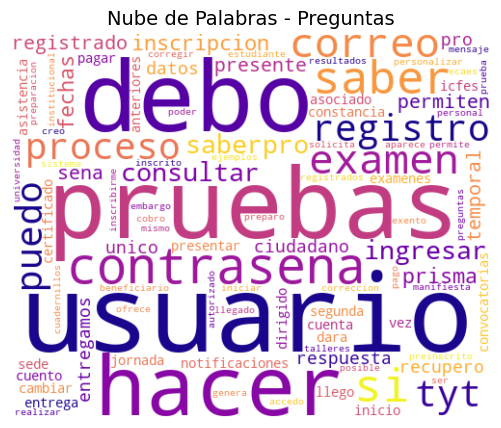

Nube de palabras - Respuestas


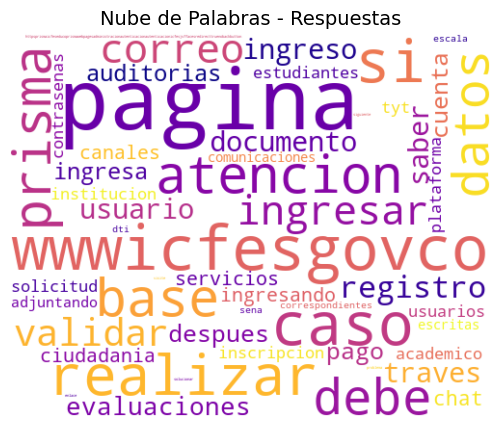

In [32]:
# Función para generar nubes de palabras con fondo blanco
def generar_nube_palabras(frecuencia_palabras, titulo):
    wordcloud = WordCloud(
        width=500, height=400, 
        background_color="white",  # Cambio de fondo a blanco
        colormap="plasma", 
        max_words=100
    ).generate_from_frequencies(frecuencia_palabras)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(titulo, fontsize=14, color="black")  # Cambio de título a negro para mejor visibilidad
    plt.show()

# Generar nubes de palabras para preguntas y respuestas con fondo blanco
print("Nube de palabras - Preguntas")
generar_nube_palabras(frecuencia_preguntas, "Nube de Palabras - Preguntas")
print("Nube de palabras - Respuestas")
generar_nube_palabras(frecuencia_respuestas, "Nube de Palabras - Respuestas")


C:\Users\santi\AppData\Local\Temp\ipykernel_19984\1113959183.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(frecuencias), y=list(palabras), palette="viridis")


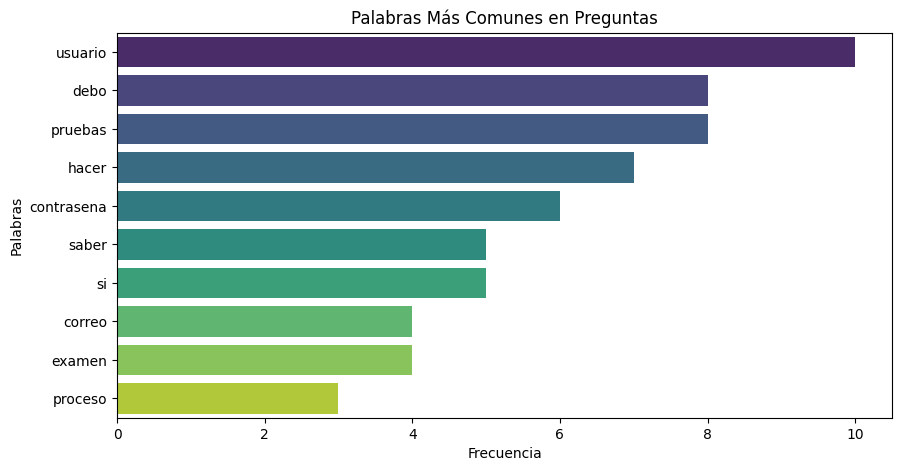

C:\Users\santi\AppData\Local\Temp\ipykernel_19984\1113959183.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(frecuencias), y=list(palabras), palette="viridis")


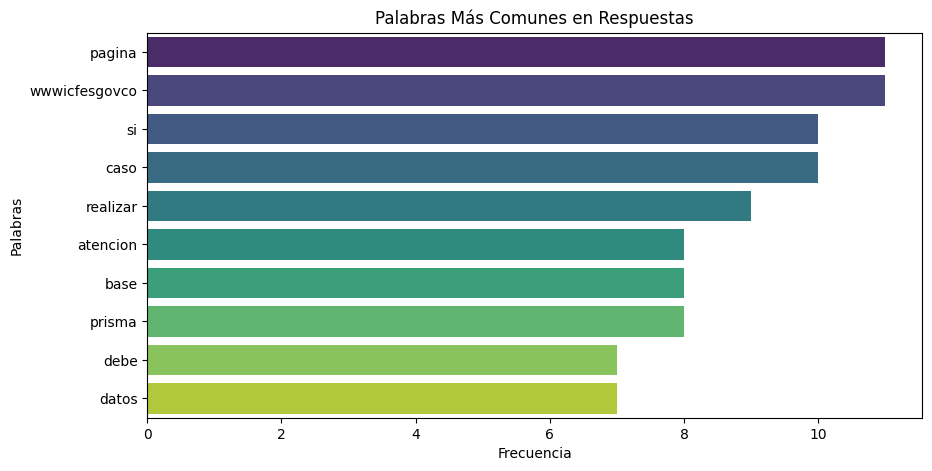

In [7]:
# Obtener las 10 palabras más comunes
top_preguntas = frecuencia_preguntas.most_common(10)
top_respuestas = frecuencia_respuestas.most_common(10)


# Función para graficar palabras más comunes
def graficar_palabras_comunes(palabras_comunes, titulo):
    palabras, frecuencias = zip(*palabras_comunes)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(frecuencias), y=list(palabras), palette="viridis")
    plt.title(titulo)
    plt.xlabel("Frecuencia")
    plt.ylabel("Palabras")
    plt.show()

# Generar gráficos para preguntas y respuestas
graficar_palabras_comunes(top_preguntas, "Palabras Más Comunes en Preguntas")
graficar_palabras_comunes(top_respuestas, "Palabras Más Comunes en Respuestas")

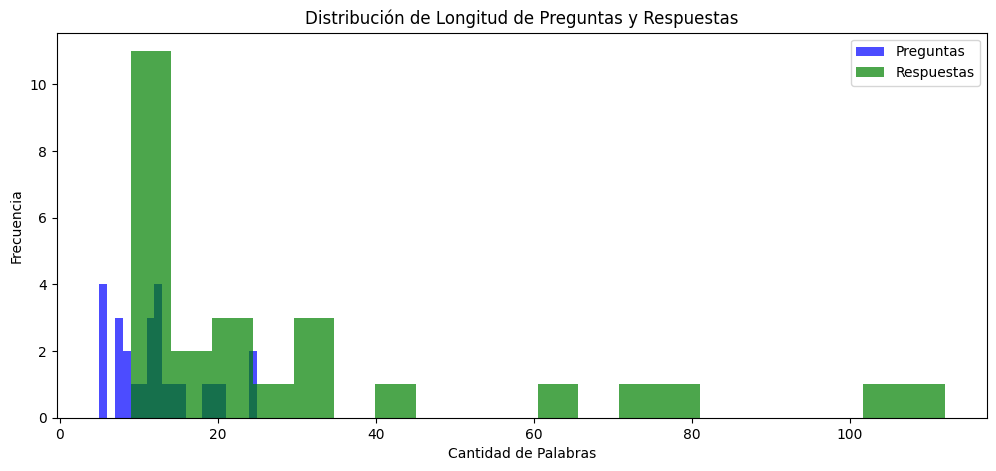

In [8]:
# Contar la cantidad de palabras en preguntas y respuestas
df_preguntas["Longitud_Pregunta"] = df_preguntas["Pregunta"].apply(lambda x: len(x.split()))
df_respuestas["Longitud_Respuesta"] = df_respuestas["Respuesta"].apply(lambda x: len(x.split()))

# Visualizar la distribución de longitudes
plt.figure(figsize=(12, 5))
plt.hist(df_preguntas["Longitud_Pregunta"], bins=20, alpha=0.7, label="Preguntas", color="blue")
plt.hist(df_respuestas["Longitud_Respuesta"], bins=20, alpha=0.7, label="Respuestas", color="green")
plt.xlabel("Cantidad de Palabras")
plt.ylabel("Frecuencia")
plt.title("Distribución de Longitud de Preguntas y Respuestas")
plt.legend()
plt.show()


In [9]:
# Función para analizar sentimiento
def analizar_sentimiento(texto):
    return TextBlob(texto).sentiment.polarity  # Devuelve un valor entre -1 (negativo) y 1 (positivo)

# Aplicar análisis a preguntas y respuestas
df_preguntas["Sentimiento"] = df_preguntas["Pregunta"].apply(analizar_sentimiento)
df_respuestas["Sentimiento"] = df_respuestas["Respuesta"].apply(analizar_sentimiento)

# Mostrar resultados
print("\n📊 Distribución de sentimiento en preguntas:")
print(df_preguntas["Sentimiento"].describe())

print("\n📊 Distribución de sentimiento en respuestas:")
print(df_respuestas["Sentimiento"].describe())




📊 Distribución de sentimiento en preguntas:
count    26.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: Sentimiento, dtype: float64

📊 Distribución de sentimiento en respuestas:
count    26.000000
mean     -0.123077
std       0.294357
min      -0.800000
25%       0.000000
50%       0.000000
75%       0.000000
max       0.000000
Name: Sentimiento, dtype: float64


In [31]:
# Función para obtener palabras únicas
def obtener_palabras_unicas(texto):
    palabras = texto.lower().split()  # Convertir a minúsculas y dividir en palabras
    palabras_unicas = set(palabras)  # Obtener palabras únicas
    return palabras_unicas

# Obtener palabras únicas de preguntas y respuestas
palabras_unicas_preguntas = set()
palabras_unicas_respuestas = set()

# Iterar sobre cada pregunta y respuesta para extraer palabras únicas
for pregunta in df_preguntas["Pregunta"]:
    palabras_unicas_preguntas.update(obtener_palabras_unicas(pregunta))

for respuesta in df_respuestas["Respuesta"]:
    palabras_unicas_respuestas.update(obtener_palabras_unicas(respuesta))

# Mostrar el total de palabras únicas y algunas de ejemplo
print(f"📌 Total de palabras únicas en preguntas: {len(palabras_unicas_preguntas)}")
print("🔍 Algunas palabras únicas en preguntas:", list(palabras_unicas_preguntas)[:20])  # Muestra 20 palabras de ejemplo

print(f"\n📌 Total de palabras únicas en respuestas: {len(palabras_unicas_respuestas)}")
print("🔍 Algunas palabras únicas en respuestas:", list(palabras_unicas_respuestas)[:20])  # Muestra 20 palabras de ejemplo


📌 Total de palabras únicas en preguntas: 130
🔍 Algunas palabras únicas en preguntas: ['institucional', 'creo', 'que', 'puedo', 'presentar', 'embargo', 'son', 'solicita', 'beneficiario', 'asociado', 'jornada', 'correccion', 'pruebas', 'ofrece', 'asistencia', 'preinscrito', 'autorizado', 'prueba', 'mi', 'sin']

📌 Total de palabras únicas en respuestas: 281
🔍 Algunas palabras únicas en respuestas: ['institucional', 'tarifas', 'tiene', 'correspondientes', 'senalar', 'que', 'informe', 'herramientas', 'nos', 'favor', 'correccion', 'tecnicos', 'convocatoria', 'preinscrito', 'consulta', 'plataforma', 'verificar', 'beneficio', 'tytlinkhttpswwwicfesgovcoevaluacionesicfesexamensabertyt', 'pero']


In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Definir el vectorizador TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df_preguntas["Pregunta"])

# Definir el número óptimo de clusters usando el método del codo
num_clusters = 6  # Puedes cambiarlo después de graficar el codo

# Aplicar K-Means con mejores parámetros
kmeans = KMeans(
    n_clusters=num_clusters, 
    init="k-means++", 
    max_iter=500, 
    n_init=20, 
    random_state=42
)

df_preguntas["Cluster"] = kmeans.fit_predict(tfidf_matrix)


In [24]:
# --- Obtener el vocabulario invertido (índice -> palabra) ---
vocabulario_invertido = {indice: palabra for palabra, indice in vectorizer.vocabulary_.items()}

# --- Iterar sobre la matriz dispersa ---
print("Elementos no nulos de la matriz TF-IDF (con preguntas):")

for i in range(tfidf_matrix.shape[0]):  # Itera sobre las filas (preguntas)
    #La siguiente linea itera sobre los indices de las columnas que SI tienen valores
    for j in tfidf_matrix.indices[tfidf_matrix.indptr[i]:tfidf_matrix.indptr[i+1]]:
        pregunta = df_preguntas["Pregunta"].iloc[i]
        palabra = vocabulario_invertido[j]
        valor_tfidf = tfidf_matrix[i, j]

        print(f"Pregunta: '{pregunta}', Palabra: '{palabra}', Coordenada: ({i}, {j}), Valor TF-IDF: {valor_tfidf}")

Elementos no nulos de la matriz TF-IDF (con preguntas):
Pregunta: 'en que fechas se dara inicio al proceso de registro inscripcion los examenes', Palabra: 'en', Coordenada: (0, 36), Valor TF-IDF: 0.2928819524383927
Pregunta: 'en que fechas se dara inicio al proceso de registro inscripcion los examenes', Palabra: 'que', Coordenada: (0, 100), Valor TF-IDF: 0.15855805580463853
Pregunta: 'en que fechas se dara inicio al proceso de registro inscripcion los examenes', Palabra: 'fechas', Coordenada: (0, 46), Valor TF-IDF: 0.2928819524383927
Pregunta: 'en que fechas se dara inicio al proceso de registro inscripcion los examenes', Palabra: 'se', Coordenada: (0, 111), Valor TF-IDF: 0.33002460840011527
Pregunta: 'en que fechas se dara inicio al proceso de registro inscripcion los examenes', Palabra: 'dara', Coordenada: (0, 25), Valor TF-IDF: 0.33002460840011527
Pregunta: 'en que fechas se dara inicio al proceso de registro inscripcion los examenes', Palabra: 'inicio', Coordenada: (0, 55), Valor T

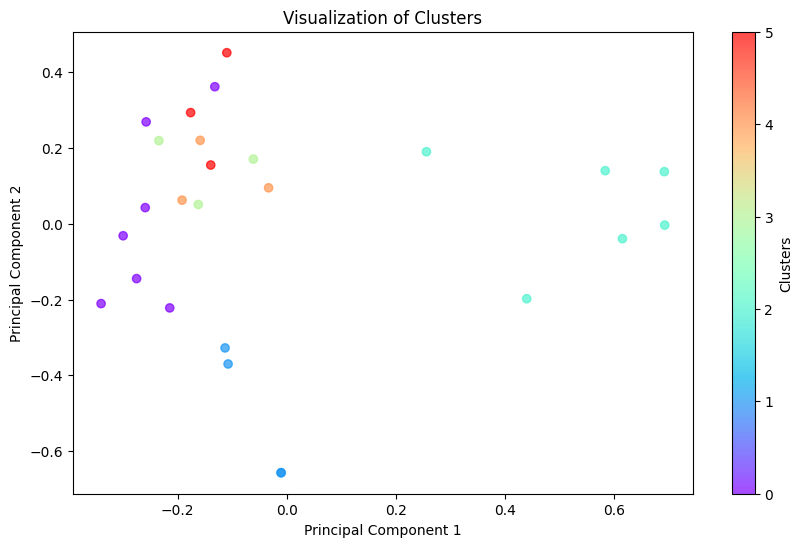

In [38]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 📌 Reduce to 2D using PCA
pca = PCA(n_components=2)
reduced_tfidf = pca.fit_transform(tfidf_matrix.toarray())

# 📌 Plot the clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_tfidf[:, 0], reduced_tfidf[:, 1], c=df_preguntas["Cluster"], cmap="rainbow", alpha=0.7)
plt.colorbar(scatter, label="Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Visualization of Clusters")
plt.show()


In [29]:
# Mostrar ejemplos de cada grupo
for cluster in range(num_clusters):
    print(f"\n📌 Categoría {cluster}:")
    print(df_preguntas[df_preguntas["Cluster"] == cluster]["Pregunta"].head(5))


📌 Categoría 0:
2     que debo hacer para presentar las pruebas icfe...
4                            debo pagar las pruebas tyt
6     que debo hacer si fui registrado para las prue...
21       ya presente la prueba saber pro que debo hacer
23    que son las pruebas saberpro es lo mismo que e...
Name: Pregunta, dtype: object

📌 Categoría 1:
7     si cuento con el usuario contrasena no permite...
10    si cuenta con el usuario contrasena no permite...
11    si al personalizar el usuario me aparece un me...
20    que debo hacer si no me haya llegado el usuari...
Name: Pregunta, dtype: object

📌 Categoría 2:
1     como puedo cambiar el correo de notificaciones...
8     como puedo consultar mi usuario contrasena tem...
9     como puedo consultar mi usuario contrasena tem...
16                           como creo mi usuario unico
17                       como recupero mi usuario unico
Name: Pregunta, dtype: object

📌 Categoría 3:
12    donde es posible consultar el estado de un est...
13    

In [14]:
print(df_preguntas["Pregunta"])

0     en que fechas se dara inicio al proceso de reg...
1     como puedo cambiar el correo de notificaciones...
2     que debo hacer para presentar las pruebas icfe...
3     el examen saber entrega certificado constancia...
4                            debo pagar las pruebas tyt
5               quien esta dirigido el examen saber tyt
6     que debo hacer si fui registrado para las prue...
7     si cuento con el usuario contrasena no permite...
8     como puedo consultar mi usuario contrasena tem...
9     como puedo consultar mi usuario contrasena tem...
10    si cuenta con el usuario contrasena no permite...
11    si al personalizar el usuario me aparece un me...
12    donde es posible consultar el estado de un est...
13    que respuesta le entregamos un ciudadano que s...
14    como realizar la correccion de datos fuera de ...
15    que respuesta le entregamos un ciudadano que m...
16                           como creo mi usuario unico
17                       como recupero mi usuari

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Vectorizar las respuestas con TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix_respuestas = vectorizer.fit_transform(df_respuestas["Respuesta"])

# Calcular similitud entre respuestas
similaridades_respuestas = cosine_similarity(tfidf_matrix_respuestas)

# Encontrar pares de respuestas muy similares
indices_respuestas_similares = np.argwhere(similaridades_respuestas > 0.85)  # Umbral de similitud alta
        
# Mostrar respuestas similares sin duplicados
print("\n📌 🔍 Respuestas muy similares detectadas:")
pares_mostrados = set()

for i, j in indices_respuestas_similares:
    if i < j:  # Solo una vez cada par (para evitar duplicados)
        par = (i, j)
        if par not in pares_mostrados:
            pares_mostrados.add(par)
            print(f"- Respuesta 1: {df_respuestas.iloc[i]['Respuesta']}")
            print(f"- Respuesta 2: {df_respuestas.iloc[j]['Respuesta']}\n")



📌 🔍 Respuestas muy similares detectadas:
- Respuesta 1: validar con el programa academico si estan correctas de lo contrario contactarse las lineas de atencion ingresando la pagina wwwicfesgovco atencion servicios la ciudadania canales de atencion linea nacional bogota traves del chat
- Respuesta 2: validarlo con el programa academico de lo contrario contactarse las lineas de atencion ingresando la pagina wwwicfesgovco atencion servicios la ciudadania canales de atencion linea nacional bogota traves del chat

